In [1]:
using CSV
using DataFrames
using Printf
using DelimitedFiles
import PyPlot; const plt = PyPlot # now do plt.plt[:hist] for example
using MultivariateStats
using Optim

In [2]:
list_of_isotherms = readdlm("../data/expt_data/list_of_isotherms.txt")

11×1 Array{Any,2}:
 "Al-MIL-53_304K.csv"  
 "MIL-101_303K.csv"    
 "MIL-101-NH2_293K.csv"
 "MIL-101-NO2_293K.csv"
 "MIL-125_298K.csv"    
 "MIL-125-NH2_298K.csv"
 "MIL-68_298K.csv"     
 "MIL-68-NH2_298K.csv" 
 "SIM-1_303K.csv"      
 "ZIF-8_298K.csv"      
 "MCM-41_298K.csv"     

In [3]:
function read_and_convert(isotherm_file::AbstractString)
    @printf("Working on file %s\n", isotherm_file)
    isotherm = CSV.read("../data/expt_data/" * isotherm_file)
    pUnit, aUnit = string.(names(isotherm))
    P0 = 0.03169 #bar
    Vp = 0.63 #cm3/g
    
    if pUnit == "Pressure(bar)"
        @printf("Pressure unit is already in bar\n")
    elseif pUnit == "Pressure(torr)"
        isotherm[1] = isotherm[1] ./ 750.06
        @printf("Converting pressure unit from torr to bar\n")
    elseif pUnit == "Pressure(kPa)"
        isotherm[1] = isotherm[1] ./ 100.0
        @printf("Converting pressure unit from kPa to bar\n")
    elseif pUnit == "Pressure(P/P0)"
        isotherm[1] = isotherm[1] .* P0
        @printf("Converting pressure unit from P/P0 to bar")
    else
        @printf("WHAT? P\n")
    end
    names!(isotherm, [Symbol("Pressure(bar)"), names(isotherm)[2]])
            
    MW_CO2 = 44.01
    if aUnit == "Adsorption(mmol/g)"
        @printf("Adsorption unit is already in mmol/g\n")
    elseif aUnit == "Adsorption(mg/g)"
        isotherm[2] = isotherm[2] ./ MW_CO2
        @printf("Converting adsorption unit from mg/g to mmol/g\n")
    elseif aUnit == "Adsorption(cm3(STP)/g)"
        isotherm[2] = isotherm[2] ./ 22.4
        @printf("Converting adsorption unit from cm3(STP)/g to mmol/g\n")
    elseif aUnit == "Adsorption(mmol/cm3)"
        isotherm[2] = isotherm[2] .* Vp
        @printf("Converting adsorption unit from mmol/cm3 to mmol/g")
    else
        @printf("WHAT? A\n")
    end
    names!(isotherm, [names(isotherm)[1], Symbol("Adsorption(mmol/g)")])
    return isotherm
end

read_and_convert (generic function with 1 method)

In [4]:
function fit_henry(df_ads::DataFrame, incl_nb_pts::Int)
    # sort by pressure
    sort!(df_ads, [Symbol("Pressure(bar)")])
    # build feature matrix
    P = zeros(incl_nb_pts, 1)
    n = zeros(incl_nb_pts)
    for (i, row) in enumerate(eachrow(df_ads))
        if i > incl_nb_pts
            break
        end
        P[i, 1] = row[Symbol("Pressure(bar)")]
        n[i] = row[Symbol("Adsorption(mmol/g)")]
    end
    # fit line without bias (henry coef) to determine henry coefficient
    K = llsq(P, n; bias=false)[1]
    return K # mmol/(g-bar)
end

fit_henry (generic function with 1 method)

In [5]:
nb_pts_to_incl_in_fitting = Dict{AbstractString, Int64}()
nb_pts_to_incl_in_fitting["Al-MIL-53_304K.csv"] = 2
nb_pts_to_incl_in_fitting["MIL-101_303K.csv"] = 3
nb_pts_to_incl_in_fitting["MIL-101-NH2_293K.csv"] = 3
nb_pts_to_incl_in_fitting["MIL-101-NO2_293K.csv"] = 3
nb_pts_to_incl_in_fitting["MIL-125_298K.csv"] = 10
nb_pts_to_incl_in_fitting["MIL-125-NH2_298K.csv"] = 10
nb_pts_to_incl_in_fitting["MIL-68_298K.csv"] = 5
nb_pts_to_incl_in_fitting["MIL-68-NH2_298K.csv"] =3 
nb_pts_to_incl_in_fitting["SIM-1_303K.csv"] = 2
nb_pts_to_incl_in_fitting["ZIF-8_298K.csv"] = 3
nb_pts_to_incl_in_fitting["MCM-41-water_298K.csv"] = 8
nb_pts_to_incl_in_fitting["MCM-41_298K.csv"] = 5

5

for MIL-101-NH2 I'd say use only the first 2-3 pts? same for MIL-101-NO2, MIL-68-NH2, SIM-1 (2 pts) just to be careful not to decrease the KH

Working on file Al-MIL-53_304K.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
Working on file MIL-101_303K.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
Working on file MIL-101-NH2_293K.csv
Converting pressure unit from torr to bar
Adsorption unit is already in mmol/g
Working on file MIL-101-NO2_293K.csv
Converting pressure unit from torr to bar
Adsorption unit is already in mmol/g
Working on file MIL-125_298K.csv
Converting pressure unit from kPa to bar
Converting adsorption unit from mg/g to mmol/g
Working on file MIL-125-NH2_298K.csv
Converting pressure unit from kPa to bar
Converting adsorption unit from mg/g to mmol/g
Working on file MIL-68_298K.csv
Converting pressure unit from torr to bar
Adsorption unit is already in mmol/g
Working on file MIL-68-NH2_298K.csv
Converting pressure unit from torr to bar
Adsorption unit is already in mmol/g
Working on file SIM-1_303K.csv
Converting pressure unit from kPa to bar
Converting adsorpt

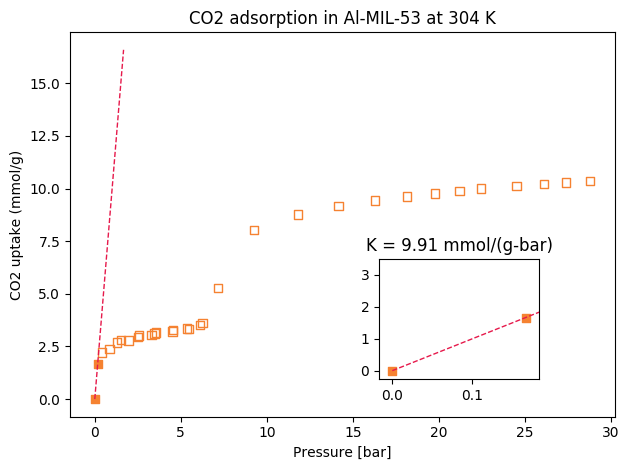

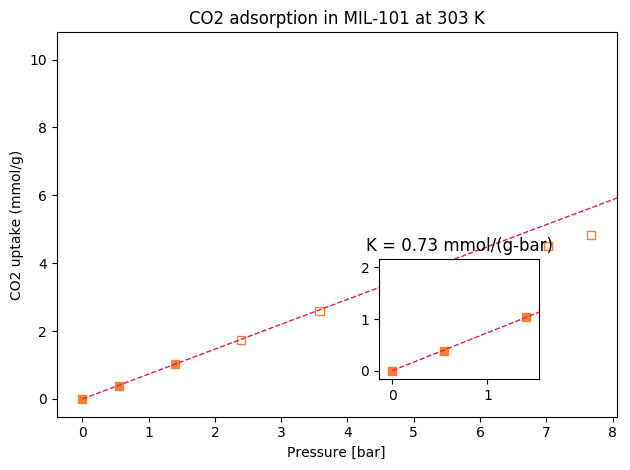

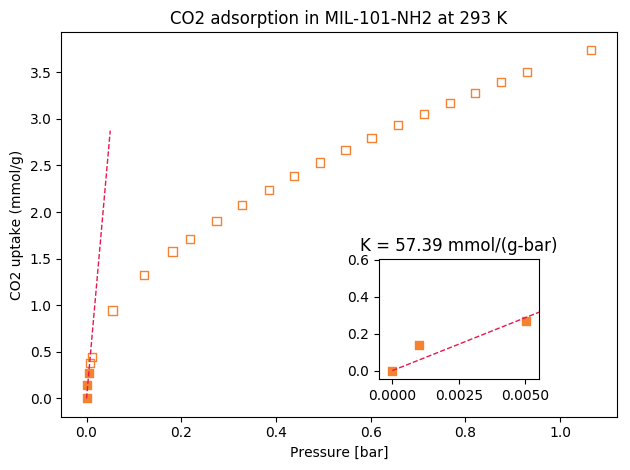

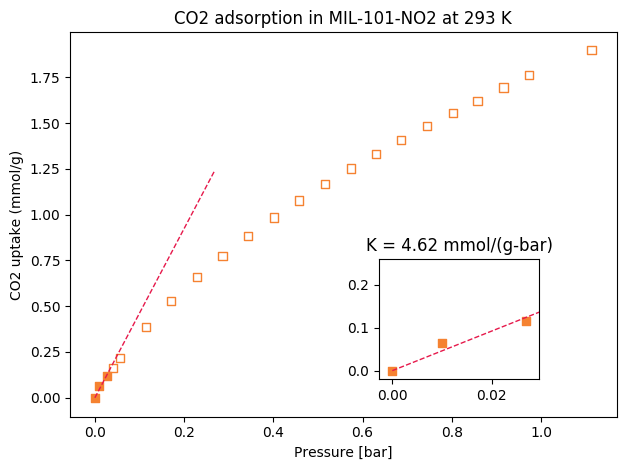

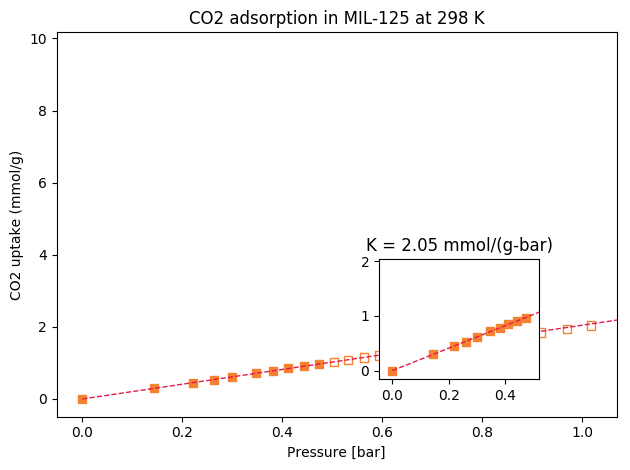

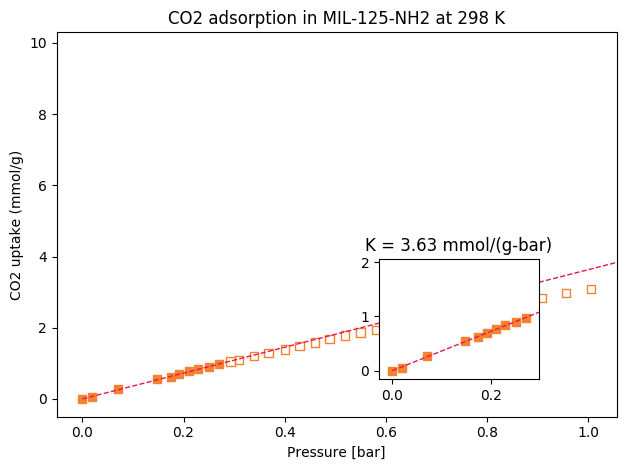

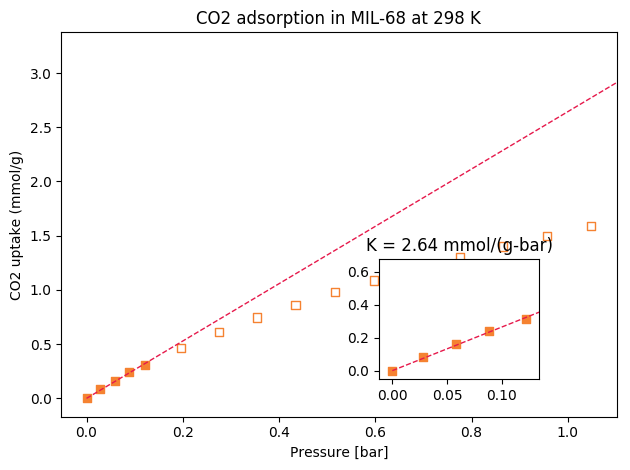

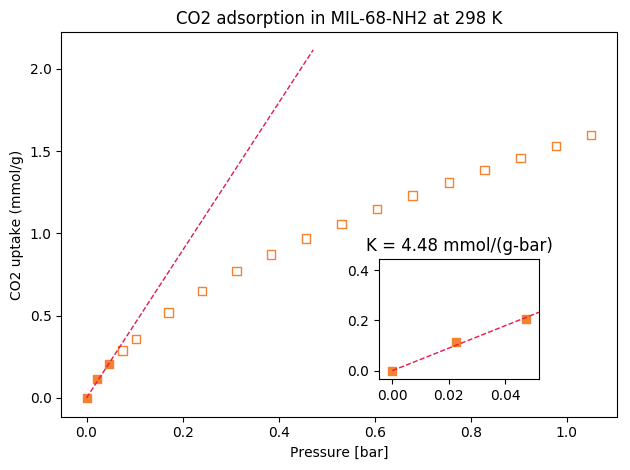

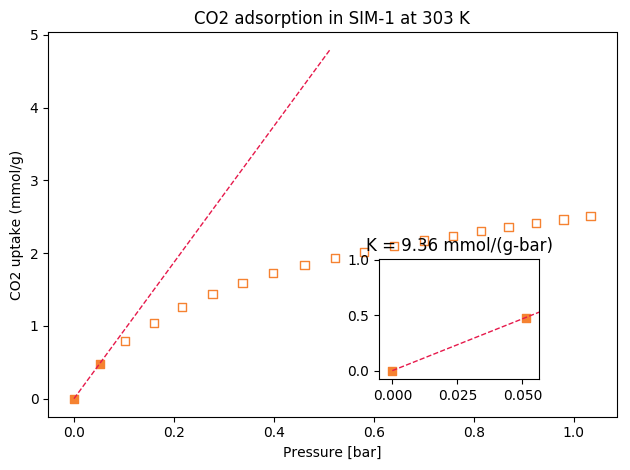

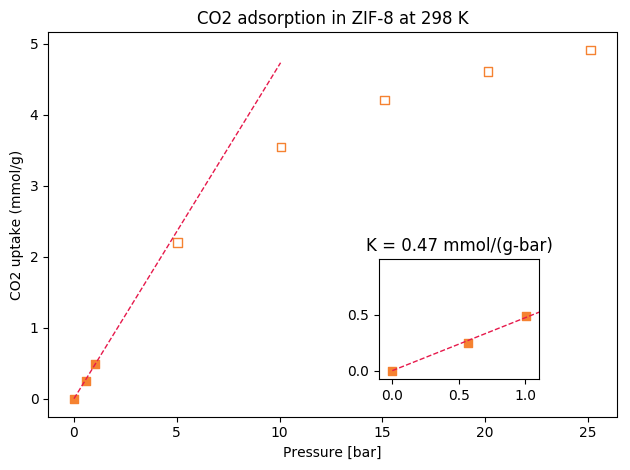

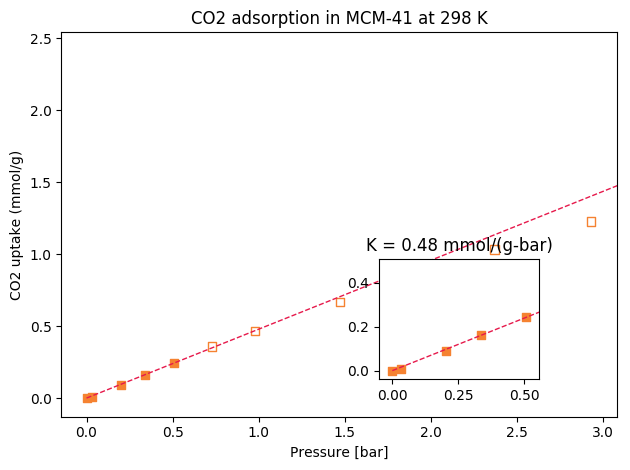

Working on file MCM-41_298K.csv
Pressure unit is already in bar
Converting adsorption unit from mmol/cm3 to mmol/g

In [6]:
for MOF in list_of_isotherms
#for MOF in ["MCM-41-water_298K.csv"]
    isotherm = read_and_convert(MOF)
    henry = fit_henry(isotherm, nb_pts_to_incl_in_fitting[MOF])
    mofstuff = split(MOF, "_")
    temperature = split(mofstuff[2], "K.")[1]
    mofname = mofstuff[1]

    fig = plt.figure()
    plt.xlabel("Pressure [bar]")
    plt.ylabel("CO2 uptake (mmol/g)")
    plt.title(@sprintf("CO2 adsorption in %s at %d K",mofname, parse(Int, temperature)))
    
    nb_pts = nb_pts_to_incl_in_fitting[MOF]
    plt.scatter(isotherm[1:nb_pts, 1], isotherm[1:nb_pts, 2], marker="s", color="#f58231")
    plt.scatter(isotherm[nb_pts+1:end, 1], isotherm[nb_pts+1:end, 2], marker="s", facecolor="none", edgecolor="#f58231")
    plt.plot([0, 10.0 * isotherm[1][nb_pts]], [0, 10.0 * isotherm[1][nb_pts] * henry], linestyle="--", color="#e6194b", linewidth=1)
    plt.xlim([-0.05*isotherm[1][end], isotherm[1][end]*1.05])
    #plt.xlim([-0.3, isotherm[1][end] + 0.3])
    
    #if isotherm[1][end] > 5
        # inset
        a = plt.axes([.6, .2, .25, .25])# , facecolor="C3")
        #P = range(0.0, stop=1.1 * dfs[gas][zeolite][Symbol("Pressure (bar)")][incl_nb_pts], length=100)
        plt.plot([0, 2.0 * isotherm[1][nb_pts]], [0, 2.0 * isotherm[1][nb_pts] * henry], linestyle="--", color="#e6194b", linewidth=1)
        plt.scatter(isotherm[1:nb_pts, 1], isotherm[1:nb_pts, 2], marker="s", color="#f58231")
        plt.xlim([-0.1*isotherm[1][nb_pts], isotherm[1][nb_pts]*1.1])
        plt.title(@sprintf("K = %.2f mmol/(g-bar)", henry))
    #end
    plt.tight_layout()
    plt.savefig("expt_water_in_" * mofname * ".png", format="png", dpi=300)
    
end

In [7]:
open("co2_henry_coefs.csv", "w") do f
    @printf(f, "MOF,CO2_henry coefficient [mmol/(g-bar)],Temperature [K]\n")
    for MOF in list_of_isotherms
        isotherm = read_and_convert(MOF)
        henry = fit_henry(isotherm, nb_pts_to_incl_in_fitting[MOF])
        mofstuff = split(MOF, "_")
        println(mofstuff[2])
        temperature = split(mofstuff[2], "K.")[1]
        mofname = mofstuff[1]
        @printf(f, "%s,%f,%d\n", mofname, henry, parse(Int64, temperature))
    end
end

Working on file Al-MIL-53_304K.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
304K.csv
Working on file MIL-101_303K.csv
Pressure unit is already in bar
Adsorption unit is already in mmol/g
303K.csv
Working on file MIL-101-NH2_293K.csv
Converting pressure unit from torr to bar
Adsorption unit is already in mmol/g
293K.csv
Working on file MIL-101-NO2_293K.csv
Converting pressure unit from torr to bar
Adsorption unit is already in mmol/g
293K.csv
Working on file MIL-125_298K.csv
Converting pressure unit from kPa to bar
Converting adsorption unit from mg/g to mmol/g
298K.csv
Working on file MIL-125-NH2_298K.csv
Converting pressure unit from kPa to bar
Converting adsorption unit from mg/g to mmol/g
298K.csv
Working on file MIL-68_298K.csv
Converting pressure unit from torr to bar
Adsorption unit is already in mmol/g
298K.csv
Working on file MIL-68-NH2_298K.csv
Converting pressure unit from torr to bar
Adsorption unit is already in mmol/g
298K.csv
Working on file SI